# Objective

Propose an analytical view of e-commerce relationship in Brazil. For this we will first go trough an exploratory data analysis using graphical tools to create self explanatory plots for better understanding what is behind braziian online purchasing. Finally we will look at customers reviews and implement Sentimental Analysis to make a text classification using Natural Language Process tools.

In [28]:
# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

# Utilities
from viz_utils import *
from custom_transformers import *
from ml_utils import *

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

In [11]:
## root path
bucket = 'all-real-datasets/Brazilian_E_Commerce'

## loading customer dataset
customer_data_key = 'olist_customers_dataset.csv'
customer_data_location = 's3://{}/{}'.format(bucket,customer_data_key)
customer = pd.read_csv(customer_data_location)
print("Shape of {} dataset is : {}".format("customer",customer.shape))

## loading geolocation dataset
geolocation_data_key = 'olist_geolocation_dataset.csv'
geolocation_data_location = 's3://{}/{}'.format(bucket,geolocation_data_key)
geolocation = pd.read_csv(geolocation_data_location)
print("Shape of {} dataset is : {}".format("geolocation",geolocation.shape))

## loading orders dataset
orders_data_key = 'olist_orders_dataset.csv'
orders_data_location = 's3://{}/{}'.format(bucket,orders_data_key)
orders = pd.read_csv(orders_data_location)
print("Shape of {} dataset is : {}".format("orders",orders.shape))

## loading order_items dataset
order_items_data_key = 'olist_order_items_dataset.csv'
order_items_data_location = 's3://{}/{}'.format(bucket,order_items_data_key)
order_items = pd.read_csv(order_items_data_location)
print("Shape of {} dataset is : {}".format("order_items",order_items.shape))

## loading order_payments dataset
order_payments_data_key = 'olist_order_payments_dataset.csv'
order_payments_data_location = 's3://{}/{}'.format(bucket,order_payments_data_key)
order_payments = pd.read_csv(order_payments_data_location)
print("Shape of {} dataset is : {}".format("order_payments",order_payments.shape))

## loading order_reviews dataset
order_reviews_data_key = 'olist_order_reviews_dataset.csv'
order_reviews_data_location = 's3://{}/{}'.format(bucket,order_reviews_data_key)
order_reviews = pd.read_csv(order_reviews_data_location)
print("Shape of {} dataset is : {}".format("order_reviews",order_reviews.shape))

## loading products dataset
products_data_key = 'olist_products_dataset.csv'
products_data_location = 's3://{}/{}'.format(bucket,products_data_key)
products = pd.read_csv(products_data_location)
print("Shape of {} dataset is : {}".format("products",products.shape))

## loading sellers dataset
sellers_data_key = 'olist_sellers_dataset.csv'
sellers_data_location = 's3://{}/{}'.format(bucket,sellers_data_key)
sellers = pd.read_csv(sellers_data_location)
print("Shape of {} dataset is : {}".format("sellers",sellers.shape))


Shape of customer dataset is : (99441, 5)
Shape of geolocation dataset is : (1000163, 5)
Shape of orders dataset is : (99441, 8)
Shape of order_items dataset is : (112650, 7)
Shape of order_payments dataset is : (103886, 5)
Shape of order_reviews dataset is : (99224, 7)
Shape of products dataset is : (32951, 9)
Shape of sellers dataset is : (3095, 4)


## Overview of dataset

In [20]:
datasets = [customer, geolocation,orders,order_items,order_payments,order_reviews,products,sellers]
names = ["customer", "geolocation","orders","order_items","order_payments","order_reviews","products","sellers"]

### create dataframe for datasets information
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['number of rows'] = [df.shape[0] for df in datasets]
data_info['number of cols'] = [df.shape[1] for df in datasets]
data_info["null_values_counter"] = [df.isnull().sum().sum() for df in datasets]
data_info["null_columns_qty"] = [len([col for col,null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info["null_columns"] = [",".join([col for col,null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

,dataset,number of rows,number of cols,null_values_counter,null_columns_qty,null_columns
0,customer,99441,5,0,0,
1,geolocation,1000163,5,0,0,
2,orders,99441,8,4908,3,"order_approved_at,order_delivered_carrier_date,order_delivered_customer_date"
3,order_items,112650,7,0,0,
4,order_payments,103886,5,0,0,
5,order_reviews,99224,7,145903,2,"review_comment_title,review_comment_message"
6,products,32951,9,2448,8,"product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm"
7,sellers,3095,4,0,0,


Now we will look at each dataset and bring some detailed parameters about the data content.we will get the following information for each dataset column:

- Column name;
- Null amount;
- Null percentage among the respective dataset;
- Data type;
- total categorical entries;

In [31]:
df_overview = pd.DataFrame({})
name_col = []
for name, df in zip(names, datasets):
    name_col += [name] * df.shape[1]
    df_overview = df_overview.append(data_overview(df))
    df_overview['dataset_name'] = name_col

df_overview = df_overview.loc[:, ['dataset_name', 'feature', 'qtd_null', 'percent_null', 'dtype', 'qtd_cat']]

df_overview

,dataset_name,feature,qtd_null,percent_null,dtype,qtd_cat
0,customer,customer_id,0,0.000000,object,99441
1,customer,customer_unique_id,0,0.000000,object,96096
2,customer,customer_zip_code_prefix,0,0.000000,int64,0
3,customer,customer_city,0,0.000000,object,4119
4,customer,customer_state,0,0.000000,object,27
0,geolocation,geolocation_zip_code_prefix,0,0.000000,int64,0
1,geolocation,geolocation_lat,0,0.000000,float64,0
2,geolocation,geolocation_lng,0,0.000000,float64,0
3,geolocation,geolocation_city,0,0.000000,object,8011
4,geolocation,geolocation_state,0,0.000000,object,27


## Exploratory Data Analysis

we can see how orders presented in Brazil , we can see orders with different status and timestamp columns such as purchase , approved , delivered and estimated delivery

### Let see how many orders we have for each state?

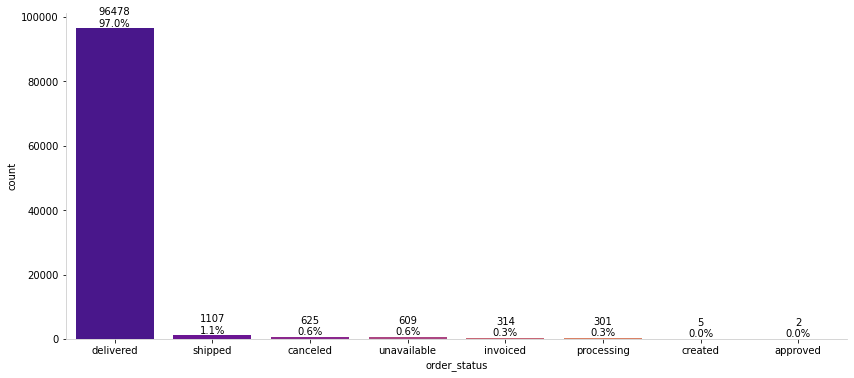

In [34]:
fig,ax = plt.subplots(figsize=(14,6))
single_countplot(orders,x = 'order_status',ax = ax)
plt.show()

By the time this dataset was created, the highest amount of orders went from delivered ones. Only 3% of all orders came from the other status.

### Is that a growing trend on e-commerce in Brazil? How can we describe a complete scenario?

In [35]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


we will extract order_purchase_timestamp to 
1. Transform timestamp columns;
2. Extract time attributes from these datetime columns (year, month, day, day of week and hour);
3. Evaluate the e-commerce scenario using this attributes.

In [36]:
# Changing the data type for date columns
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']

In [38]:
for col in timestamp_cols:
    orders[col] = pd.to_datetime(orders[col])

In [40]:
# Extracting attributes for purchase date - Year and Month
orders['order_purchase_year'] = orders['order_purchase_timestamp'].apply(lambda x: x.year)
orders['order_purchase_month'] = orders['order_purchase_timestamp'].apply(lambda x: x.month)
orders['order_purchase_month_name'] = orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
orders['order_purchase_year_month'] = orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
orders['order_purchase_date'] = orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

In [41]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,Oct,201710,20171002
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,7,Jul,201807,20180724
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,8,Aug,201808,20180808
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,11,Nov,201711,20171118
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2,Feb,201802,20180213


In [44]:
# Extracting attributes for purchase date - day and day of week
orders['order_purchase_day'] = orders['order_purchase_timestamp'].apply(lambda x: x.day)
orders['order_purchase_dayofweek'] = orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
orders['order_purchase_dayofweek_name'] = orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

In [43]:
# Extracting attributes for purchase date - Hour and time of day
orders['order_purchase_hour'] = orders['order_purchase_timestamp'].apply(lambda x: x.day)
orders['order_purchase_dayofweek'] = orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
orders['order_purchase_dayofweek_name'] = orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

In [49]:
# Extracting attributes for purchase date - Hour and time of day
orders['order_purchase_hour'] = orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1 , 6 , 12 , 18 , 23]
hours_labels = ["Dawn", "Morning","Afternoon","Night"]
orders['order_purchase_time_day'] = pd.cut(orders['order_purchase_hour'],hours_bins,labels = hours_labels)

In [50]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,7,Jul,201807,20180724,24,1,Tue,20,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,11,Nov,201711,20171118,18,5,Sat,19,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2,Feb,201802,20180213,13,1,Tue,21,Night


So now we can answer these questions 
1. Is there any growing trend on brazilian e-commerce?
2. On what day of week brazilians customers tend to do online purchasing?
3. What time brazilians customers tend do buy (Dawn, Morning, Afternoon or Night)?

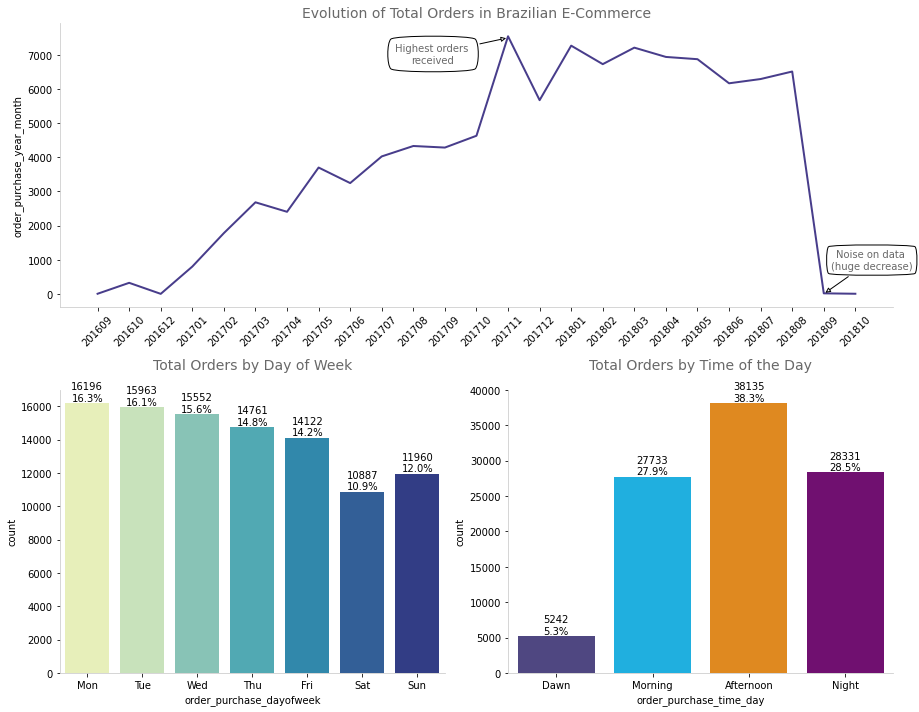

In [54]:
fig = plt.figure(constrained_layout = True,figsize = (13,10))

gs = GridSpec(2,2,figure = fig)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])

# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=orders['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)
ax1.annotate(f'Highest orders \nreceived', (13, 7500), xytext=(-75, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Noise on data \n(huge decrease)', (23, 0), xytext=(48, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
format_spines(ax1, right_border=False)  
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')

# Barchart - Total of orders by day of week
single_countplot(orders, x='order_purchase_dayofweek', ax=ax2, order=False, palette='YlGnBu')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total Orders by Day of Week', size=14, color='dimgrey', pad=20)

# Barchart - Total of orders by time of the day
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
single_countplot(orders, x='order_purchase_time_day', ax=ax3, order=False, palette=day_color_list)
ax3.set_title('Total Orders by Time of the Day', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

with the plot above we can conclude :
- E-commerce on Brazil really has a growing trend along the time. We can see some seasonality with peaks at specific months, but in general we can see clear that the customers are more prone to buy things online than before.

- Monday are the prefered day for brazillian's customers to buy and they tend to buy more afternoon.

- We have the sharp decreasing on August 2018 maybe of that related to noise on data.

### E-commerce: a comparison between 2017 and 2018 ?